In [1]:
import warnings
import numpy as np
import sympy
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import requests
from PIL import Image, ImageDraw
from io import BytesIO
from lang_sam import LangSAM
import cv2

c:\Users\aaaab\.conda\envs\merced\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\aaaab\.conda\envs\merced\lib\site-packages\groundingdino\models\GroundingDINO\ms_deform_attn.py:33: UserWarning: Failed to load custom C++ ops. Running on CPU mode Only!
  warnings.warn("Failed to load custom C++ ops. Running on CPU mode Only!")


In [2]:
def download_image(url):
    response = requests.get(url)
    response.raise_for_status()
    return Image.open(BytesIO(response.content)).convert("RGB")


def save_mask(mask_np, filename):
    mask_image = Image.fromarray((mask_np * 255).astype(np.uint8))
    mask_image.save(filename)


def display_image_with_masks(image, masks):
    num_masks = len(masks)

    fig, axes = plt.subplots(1, num_masks + 1, figsize=(15, 5))
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    for i, mask_np in enumerate(masks):
        axes[i + 1].imshow(mask_np, cmap="gray")
        axes[i + 1].set_title(f"Mask {i+1}")
        axes[i + 1].axis("off")

    plt.tight_layout()
    plt.show()


def display_image_with_boxes(image, boxes, logits):
    fig, ax = plt.subplots()
    ax.imshow(image)
    ax.set_title("Image with Bounding Boxes")
    ax.axis("off")

    for box, logit in zip(boxes, logits):
        x_min, y_min, x_max, y_max = box
        confidence_score = round(
            logit.item(), 2
        )  # Convert logit to a scalar before rounding
        box_width = x_max - x_min
        box_height = y_max - y_min

        # Draw bounding box
        rect = plt.Rectangle(
            (x_min, y_min),
            box_width,
            box_height,
            fill=False,
            edgecolor="red",
            linewidth=2,
        )
        ax.add_patch(rect)

        # Add confidence score as text
        ax.text(
            x_min,
            y_min,
            f"Confidence: {confidence_score}",
            fontsize=8,
            color="red",
            verticalalignment="top",
        )

    plt.show()


def print_bounding_boxes(boxes):
    print("Bounding Boxes:")
    for i, box in enumerate(boxes):
        print(f"Box {i+1}: {box}")


def print_detected_phrases(phrases):
    print("\nDetected Phrases:")
    for i, phrase in enumerate(phrases):
        print(f"Phrase {i+1}: {phrase}")


def print_logits(logits):
    print("\nConfidence:")
    for i, logit in enumerate(logits):
        print(f"Logit {i+1}: {logit}")


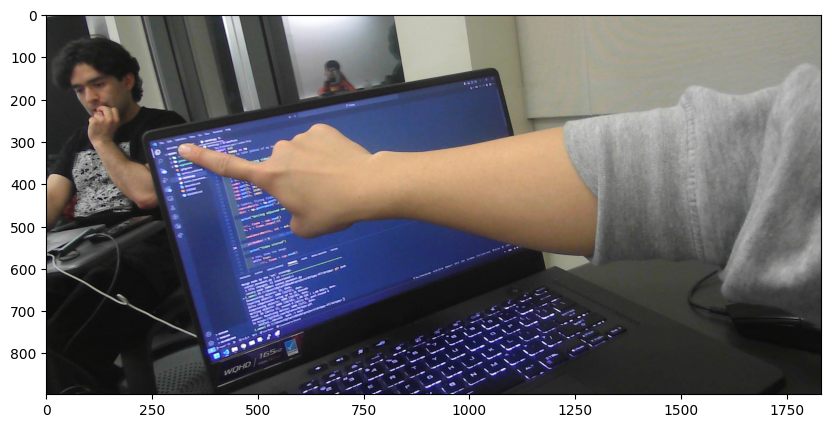

In [3]:
text_prompt = "screen"
image = 'images/0.jpg'

image = cv2.imread(image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

In [4]:
model = LangSAM(sam_type='vit_b')
image_pil = Image.fromarray(image)
masks, boxes, phrases, logits = model.predict(image_pil, text_prompt)

c:\Users\aaaab\.conda\envs\merced\lib\site-packages\torch\functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased
Model loaded from C:\Users\aaaab\.cache\huggingface\hub\models--ShilongLiu--GroundingDINO\snapshots\a94c9b567a2a374598f05c584e96798a170c56fb\groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


c:\Users\aaaab\.conda\envs\merced\lib\site-packages\transformers\modeling_utils.py:962: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
c:\Users\aaaab\.conda\envs\merced\lib\site-packages\torch\utils\checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
c:\Users\aaaab\.conda\envs\merced\lib\site-packages\torch\utils\checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


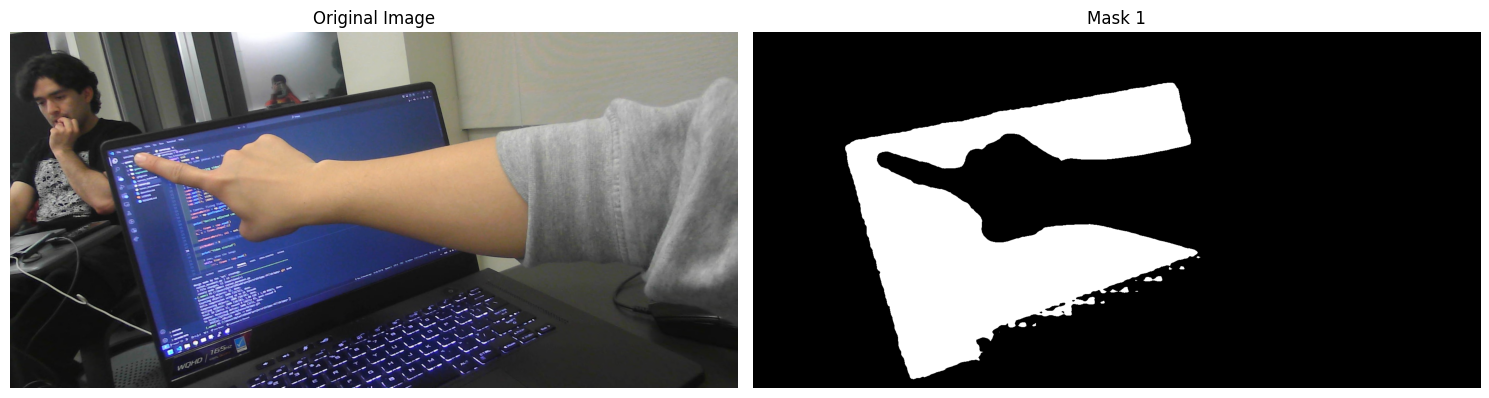

In [5]:
masks_np = [mask.squeeze().cpu().numpy() for mask in masks]
display_image_with_masks(image_pil, masks_np)

In [6]:
def appx_best_fit_ngon_from_mask(mask, n: int = 4):
    # Assume mask is already a binary mask, so we directly find contours on it
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    hull = cv2.convexHull(contours[0])
    hull = np.array(hull).reshape((len(hull), 2))

    # Convert to sympy Points
    hull = [sympy.Point(*pt) for pt in hull]

    # Iteratively approximate to n-gon
    while len(hull) > n:
        best_candidate = None
        for edge_idx_1 in range(len(hull)):
            edge_idx_2 = (edge_idx_1 + 1) % len(hull)
            adj_idx_1 = (edge_idx_1 - 1) % len(hull)
            adj_idx_2 = (edge_idx_1 + 2) % len(hull)

            edge_pt_1, edge_pt_2 = hull[edge_idx_1], hull[edge_idx_2]
            adj_pt_1, adj_pt_2 = hull[adj_idx_1], hull[adj_idx_2]

            subpoly = sympy.Polygon(adj_pt_1, edge_pt_1, edge_pt_2, adj_pt_2)
            angle1, angle2 = subpoly.angles[edge_pt_1], subpoly.angles[edge_pt_2]

            if sympy.N(angle1 + angle2) <= sympy.pi:
                continue

            adj_edge_1, adj_edge_2 = sympy.Line(adj_pt_1, edge_pt_1), sympy.Line(edge_pt_2, adj_pt_2)
            intersect = adj_edge_1.intersection(adj_edge_2)[0]

            area = sympy.N(sympy.Triangle(edge_pt_1, intersect, edge_pt_2).area)
            if best_candidate and best_candidate[1] < area:
                continue

            better_hull = list(hull)
            better_hull[edge_idx_1] = intersect
            del better_hull[edge_idx_2]
            best_candidate = (better_hull, area)

        if not best_candidate:
            raise ValueError("Could not find the best fit n-gon!")

        hull = best_candidate[0]

    # Convert back to integer coordinates for drawing
    hull = [(int(x.evalf()), int(y.evalf())) for x, y in hull]

    return hull

def find_largest_component(mask):
    # Ensure the mask is in the correct format
    mask_uint8 = mask.astype(np.uint8) * 255

    # Find all connected components (blobs in the mask)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask_uint8, connectivity=8)

    # Size of each component will be in stats[:, -1], excluding label 0 (background)
    sizes = stats[1:, -1] 

    # Find the largest non-background component
    largest_label = 1 + np.argmax(sizes)  # Add 1 because we excluded background

    # Create a mask for the largest component
    largest_component = (labels == largest_label).astype(np.uint8)

    return largest_component

C:\Users\aaaab\AppData\Local\Temp\ipykernel_33764\266467980.py:15: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(x + (x[0],), y + (y[0],), 'r-', marker='o', markersize=5, linestyle="-", color='green')  # Close the shape
C:\Users\aaaab\AppData\Local\Temp\ipykernel_33764\266467980.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  ax.plot(x + (x[0],), y + (y[0],), 'r-', marker='o', markersize=5, linestyle="-", color='green')  # Close the shape


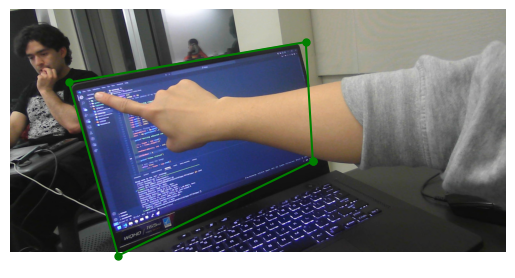

In [7]:
# Calculate the best-fit quadrilateral
mask = find_largest_component(masks_np[0])
hull = appx_best_fit_ngon_from_mask(mask, n=4)
# Convert PIL Image to NumPy array for plotting
image_np = np.array(image_pil)

# Create figure and axes for plotting
fig, ax = plt.subplots()

# Display the original image
ax.imshow(image_np)

# Draw the quadrilateral
x, y = zip(*hull)  # Unpack the hull points
ax.plot(x + (x[0],), y + (y[0],), 'r-', marker='o', markersize=5, linestyle="-", color='green')  # Close the shape

plt.axis('off')  # Hide the axes
plt.show()

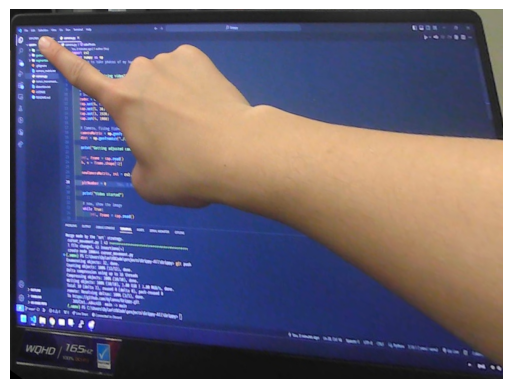

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def order_points(pts):
    # Sort the points based on their x-coordinates
    x_sorted = pts[np.argsort(pts[:, 0]), :]

    # Grab the left-most and right-most points from the sorted
    # x-coordinate points
    left_most = x_sorted[:2, :]
    right_most = x_sorted[2:, :]

    # Now, sort the left-most coordinates according to their
    # y-coordinates so we can grab the top-left and bottom-left points
    left_most = left_most[np.argsort(left_most[:, 1]), :]
    (tl, bl) = left_most

    # Now that we have the top-left coordinate, use it as an
    # anchor to calculate the Euclidean distance between the
    # top-left and right-most points; by the Pythagorean
    # theorem, the point with the largest distance will be
    # our bottom-right point
    D = cdist(tl[np.newaxis], right_most, "euclidean")[0]
    (br, tr) = right_most[np.argsort(D)[::-1], :]

    # Return the coordinates in top-left, top-right,
    # bottom-right, and bottom-left order
    return np.array([tl, tr, br, bl], dtype="float32")

# The hull points you have obtained

hull_points = order_points(np.array(hull))

width, height = 800, 600
destination_points = np.array([[0, 0], [width-1, 0], [width-1, height-1], [0, height-1]], dtype=np.float32)

# Calculate the perspective transform matrix
M = cv2.getPerspectiveTransform(hull_points, destination_points)

# Apply the transform to get the warped image
warped_image = cv2.warpPerspective(image_np, M, (width, height))

# Show the result using matplotlib
plt.imshow(warped_image)
plt.axis('off')  # Hide the axes
plt.show()

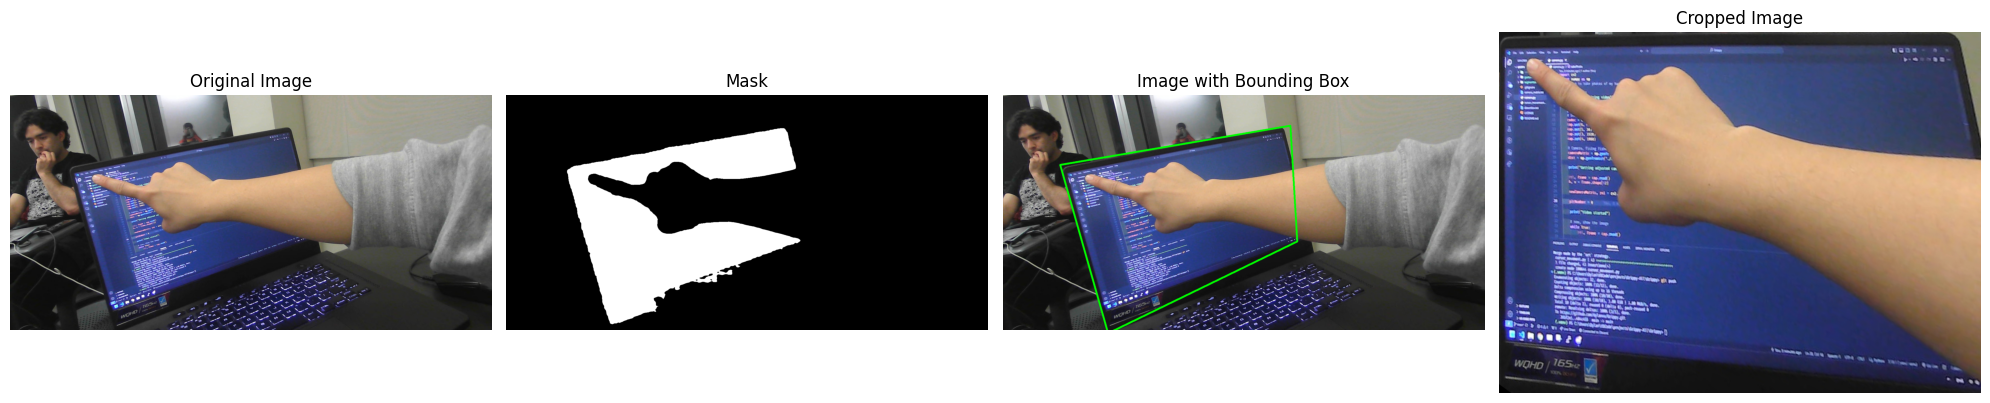

In [9]:
# Convert mask back to an image
mask_image = Image.fromarray(mask * 255)

# Draw the quadrilateral on the original image
image_with_quad = image_np.copy()
cv2.polylines(image_with_quad, [np.array(hull)], isClosed=True, color=(0, 255, 0), thickness=5)

# Plotting all the images side by side
fig, axs = plt.subplots(1, 4, figsize=(20, 5))  # Adjust the size as needed

# Original image
axs[0].imshow(image_np)
axs[0].set_title('Original Image')
axs[0].axis('off')

# Mask image
axs[1].imshow(mask_image, cmap='gray')
axs[1].set_title('Mask')
axs[1].axis('off')

# Image with bounding box (quadrilateral)
axs[2].imshow(image_with_quad)
axs[2].set_title('Image with Bounding Box')
axs[2].axis('off')

# Perspective-transformed (cropped) image
axs[3].imshow(warped_image)
axs[3].set_title('Cropped Image')
axs[3].axis('off')

plt.tight_layout()
plt.show()